In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM

In [2]:
df = pd.read_csv('df_model.csv',index_col=[0])
df.sample(5)

,stems,Label
848,"['real', 'theater', 'present', 'program', '202...",1
286,"['five', 'million', 'astrazeneca', 'vaccin', '...",0
830,"['famou', 'market', 'profit', 'well', 'known',...",0
431,"['sinc', 'bob', 'dylan', 'got', 'rid', 'sever'...",1
827,"['french', 'valentin', 'stay', 'lui', 'suarez']",1


In [3]:
stems = []
for i in df.stems:
    stems.append(''.join(re.findall(r'[\sa-z]', i)))
df['stems'] = stems

In [4]:
df.head()

,stems,Label
0,day ago began new concert tour think want sing...,1
1,attende festiv chao first day queue rapid an...,0
2,saturday mark th anniversari death leader door...,1
3,current patient admit covid yesterday spa...,0
4,summer cultur offer madrid increasingli inexha...,1


In [5]:
#Teniamos 4500 palabras distintas y ya las reducimos con los stems.
VOCAB_SIZE=3800

encoded_stems = [one_hot(i, VOCAB_SIZE) for i in stems]
print('1er encoded stems:', encoded_stems[0])


1er encoded stems: [1042, 881, 388, 2917, 8, 2331, 3268, 3532, 1423, 542, 3731, 2303, 989, 3176, 1614, 3543, 2260, 3583, 678, 2771]


In [6]:
index = []
st = []
for i,j in enumerate(encoded_stems):
    index.append(i)
    st.append(len(j))
    
df_len_paf = pd.DataFrame({'Index_stem': index,
                            'Length_stem': st})


In [7]:
df_len_paf.nlargest(30,'Length_stem')

,Index_stem,Length_stem
73,73,30
90,90,29
138,138,29
184,184,29
249,249,29
389,389,29
12,12,28
125,125,28
151,151,28
239,239,28


In [8]:
MAX_LENGTH = 26
padded_stems = pad_sequences(encoded_stems, maxlen=MAX_LENGTH, padding='post')
print(padded_stems)

[[1042  881  388 ...    0    0    0]
 [3400   35 2612 ...    0    0    0]
 [ 588  309 3596 ...    0    0    0]
 ...
 [1085  723  839 ...    0    0    0]
 [1949 1841 3414 ...    0    0    0]
 [1604 3339 2665 ...    0    0    0]]


In [9]:
labels = pd.DataFrame(df.Label.values)

In [10]:
df_padded = pd.DataFrame(padded_stems)
df_padded['Label'] = labels

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_padded.drop(columns=['Label']),
                                                    df_padded['Label'],
                                                    test_size=0.25,
                                                    random_state=42)
print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape y_train:', y_train.shape)
print('Shape y_test:', y_test.shape)

Shape X_train: (750, 26)
Shape X_test: (250, 26)
Shape y_train: (750,)
Shape y_test: (250,)


In [12]:
model = Sequential()
embedding_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = 1,
                            input_length = MAX_LENGTH)
model.add(embedding_layer)

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss='binary_crossentropy',
             metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 1)             3800      
_________________________________________________________________
dense (Dense)                (None, 26, 1)             2         
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.fit(X_train, y_train, epochs=25)

Epoch 1/25
24/24 [==============================] - 0s 1ms/step - loss: 0.6928 - acc: 0.5128
Epoch 2/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6919 - acc: 0.5308
Epoch 3/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6921 - acc: 0.5268
Epoch 4/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6916 - acc: 0.5303
Epoch 5/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6901 - acc: 0.5514
Epoch 6/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6898 - acc: 0.5566
Epoch 7/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6887 - acc: 0.5643
Epoch 8/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6873 - acc: 0.5826
Epoch 9/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6861 - acc: 0.5923
Epoch 10/25
24/24 [==============================] - 0s 2ms/step - loss: 0.6857 - acc: 0.5818
Epoch 11/25
24/24 [==============================] - 0s 2ms/step - lo

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
loss,accuracy

8/8 [==============================] - 0s 1ms/step - loss: 0.6844 - acc: 0.5209


(0.6843556761741638, 0.5209230780601501)

#### Redes Recurrentes

In [15]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=32, input_length=MAX_LENGTH))
model.add(LSTM(32, input_shape=(MAX_LENGTH,)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 32)            121600    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 129,953
Trainable params: 129,953
Non-trainable params: 0
_________________________________________________________________


In [16]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test,
                                                   y_test,
                                                   test_size=0.5,
                                                   random_state=42)

In [17]:
call = keras.callbacks.EarlyStopping(patience=4)

In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_valid,y_valid), callbacks=call)

Epoch 1/20
6/6 [==============================] - 3s 228ms/step - loss: 0.6927 - accuracy: 0.5354 - val_loss: 0.6895 - val_accuracy: 0.5840
Epoch 2/20
6/6 [==============================] - 0s 35ms/step - loss: 0.6927 - accuracy: 0.5030 - val_loss: 0.6907 - val_accuracy: 0.5840
Epoch 3/20
6/6 [==============================] - 0s 30ms/step - loss: 0.6917 - accuracy: 0.5463 - val_loss: 0.6902 - val_accuracy: 0.5840
Epoch 4/20
6/6 [==============================] - 0s 35ms/step - loss: 0.6911 - accuracy: 0.5398 - val_loss: 0.6905 - val_accuracy: 0.5920
Epoch 5/20
6/6 [==============================] - 0s 33ms/step - loss: 0.6897 - accuracy: 0.5554 - val_loss: 0.6889 - val_accuracy: 0.5920
Epoch 6/20
6/6 [==============================] - 0s 36ms/step - loss: 0.6862 - accuracy: 0.5767 - val_loss: 0.6861 - val_accuracy: 0.5840
Epoch 7/20
6/6 [==============================] - 0s 34ms/step - loss: 0.6748 - accuracy: 0.6951 - val_loss: 0.6735 - val_accuracy: 0.6880
Epoch 8/20
6/6 [==========

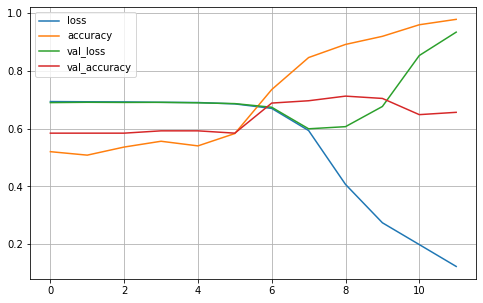

In [19]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.show()

In [20]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.9227 - accuracy: 0.6560


[0.9226838946342468, 0.656000018119812]